In [22]:
import pandas as pd

from IPython.display import HTML

from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors, rdmolops
from rdkit.Chem.MolStandardize.rdMolStandardize import StandardizeSmiles

In [23]:
# Defining a function to print all structures in mol correctly
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Read CSV

In [24]:
approved_drugs = pd.read_csv("../data/manual_curated_datasets/concatenated_dataset.csv")
approved_drugs.head(5)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192


# REMOVE UNWANTED MOLECULES

some molecules that were removed from the manually curated fragments dataset, are still present in the main dataset. We are going to remove them here

In [25]:
# list of pref_names to be removed
remove_structures = [
"AMMONIUM LACTATE",
"SEVELAMER",
"MESNA",
"ALUMINUM ACETATE",
"AMIFAMPRIDINE PHOSPHATE",
"LITHIUM CITRATE",
"SEVELAMER CARBONATE",
"CYSTEAMINE BITARTRATE",
"PINACIDIL",
"LITHIUM CITRATE",
"SULFADIAZINE, SILVER",
"METHYLENE BLUE",
"ACRISORCIN",
"DIMENHYDRINATE",
"BUTORPHANOL TARTRATE",
"OMEGA-3-CARBOXYLIC ACIDS",
"CEFIDEROCOL SULFATE TOSYLATE",
"GENTAMICIN SULFATE"
]

In [26]:
approved_drugs[approved_drugs["pref_name"].isin(remove_structures)]

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw
39,MESNA,O=S(=O)(O)CCS,CHEMBL1098319,1988,Small molecule,Detoxifying Agent,0,False,0,True,0,True,True,False,141.975836052
324,PINACIDIL,CC(N/C(=N\C#N)Nc1ccncc1)C(C)(C)C,CHEMBL1159,1989,Small molecule,Antihypertensive,0,False,0,True,0,True,False,False,245.164045608
530,METHYLENE BLUE,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,CHEMBL191083,2016,Small molecule,Antidote (to cyanide poisoning); Antimethemogl...,0,False,0,True,0,False,True,False,284.12159499609


In [27]:
approved_drugs = approved_drugs.drop([39, 324, 530])

In [28]:
approved_drugs.shape

(2821, 15)

# KEEP RIGHT FRAGMENTS

This concatenated dataset contains the three datasets joined in the formed jupyter notebook:

- Main Dataset
- Curated fragments Dataset
- Curated SMILES and Years Dataset

In the curated fragments dataset, we removed some molecules that are irrelevant for the research in question. We also selected a few molecules that are smaller than their fragments, so we will keep the smallest fragment for them. 

On the mains dataset, several molecules still contain their fragments. We will remove the fragments for all these molecules, keeping the largest fragment (the drug).

In [29]:
# Creating MOL column
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="SMILES")

RDKit WARNING: [18:27:13] WARNING: not removing hydrogen atom without neighbors
[18:27:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:27:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:27:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:27:13] WARNING: not removing hydrogen atom without neighbors
[18:27:13] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [18:27:13] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [18:27:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:27:13] WARNING: not removing hydrogen atom without neighbors
[18:27:13] WARNING: not removing hydrogen atom without neighbors
[18:27:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:27:13] Explicit valence for atom # 0 N, 4, is greater than permitted


In [30]:
# Two molecules contain Pt, and can't be turned into mol correctly, we will remove them

approved_drugs = approved_drugs[~approved_drugs["ROMol"].isnull()].reset_index(drop=True)
approved_drugs.shape

(2819, 16)

In [31]:
# These are the drugs (pref_name) that are smaller than their fragments. 
# The special function keep_smallest_fragment, will be applied for them.

keep_smallest = [
    "METHENAMINE HIPPURATE",
    "DEXTROAMPHETAMINE SACCHARATE",
    "IMIPRAMINE PAMOATE",
    "HYDROXYZINE PAMOATE",
    "OLANZAPINE PAMOATE",
    "PIPERAZINE CITRATE",
]

In [32]:
# Keep fragments functions

def keep_largest_fragment(mol):
    '''
    This function reads a mol object and returns the largest fragment, as mol
    '''
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

def keep_smallest_fragment(mol):
    '''
    This function reads a mol object and returns the smallest fragment, as mol
    '''
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    smallest_mol = min(frags, key=lambda x: x.GetNumAtoms())
    return smallest_mol

def keep_correct_fragment(row):
    '''
    This function recieves a DataFrame row, analyzes if it need the keep_largest_fragment or keep_smallest_fragment
    function applied to it, and returns the correct fragment, as SMILES
    '''
    if row["pref_name"] in keep_smallest:
        frag = keep_smallest_fragment(row["ROMol"])
    else:
        frag = keep_largest_fragment(row["ROMol"])
    return Chem.MolToSmiles(frag)
    

In [33]:
approved_drugs["correct_fragment"] = approved_drugs.apply(keep_correct_fragment, axis=1)

(2819, 17)


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,ROMol,correct_fragment
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284,,CC(=O)NO
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368,,NC(=O)NO
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224,,NCCS
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812,,C[S+](C)[O-]
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192,,Cc1cn[nH]c1

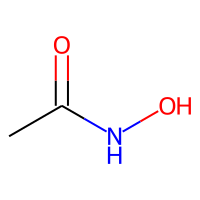
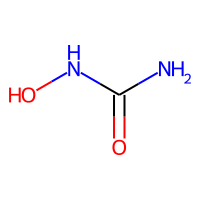
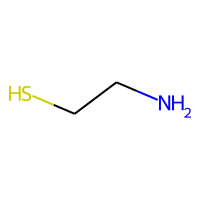
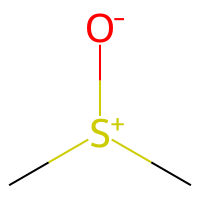
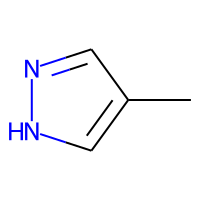

In [34]:
print(approved_drugs.shape)
show_df(approved_drugs.head())

# Neutralizing and Standardizing molecules

We need to neutralize the molecules before looking for duplicates.

We also need to standardizer the SMILES, to be sure same molecules have the same SMILES string (we do this by transforming the SMILES into mol, then into SMILES again).

In [35]:
def neutralize_standardize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return Chem.MolToSmiles(mol)

In [36]:
# calculate ROMol from the correct smiles
approved_drugs = approved_drugs.drop("ROMol", axis=1)
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="correct_fragment")

In [37]:
approved_drugs["correct_fragment"] = approved_drugs["ROMol"].apply(neutralize_standardize_atoms)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,mw,correct_fragment,ROMol
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,75.0320284,CC(=O)NO,
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,76.027277368,NC(=O)NO,
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,77.029920224,NCCS,
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,78.013935812,C[S+](C)[O-],
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,82.053098192,Cc1cn[nH]c1,

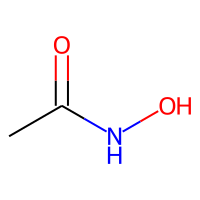
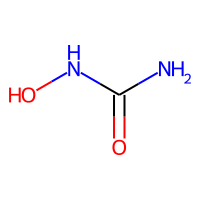
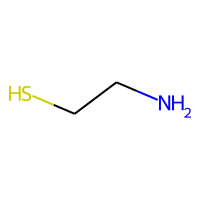
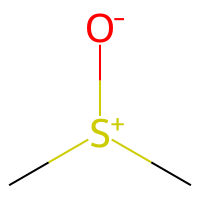
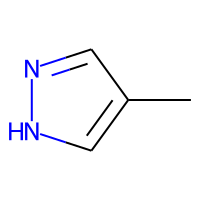

In [38]:
approved_drugs.shape
show_df(approved_drugs.head())

# Checking for Repeated Molecules

The original dataset has repeated molecules. It also had molecules in salt form and neutral form. We performed nautralization in the molecules, therefore, these molecules are now the same. We need to remove all of these repeated molecules, but withou losing information about their parameters.

### Analyzing number of unique molecules in the dataset  

In [39]:
whole_dataset_size = len(approved_drugs)
number_unique_molecules = len(approved_drugs["correct_fragment"].unique())

print(f"Whole dataset: {whole_dataset_size}\n\
Unique molecules: {number_unique_molecules}\n\
      ")


Whole dataset: 2819
Unique molecules: 1909
Molecules with duplicates: 910


### Separating Datasets with only unique molecules, and only repeated ones

In [40]:
# separating dataset with only repeated molecules
duplicated = approved_drugs[approved_drugs["correct_fragment"].duplicated(keep=False)]
duplicated.shape

(1731, 17)

In [41]:
# separating dataset with only unique molecules
approved_drugs = approved_drugs[~approved_drugs["correct_fragment"].duplicated(keep=False)]
approved_drugs.shape

(1088, 17)

In [51]:
print(
    f"""
    Number of molecules in the dataset with only unique molecules: {len(approved_drugs)}
                                                                        +
    Number of unique molecules in the dataset with only repeated :  {len(duplicated["correct_fragment"].unique())}
                                                                  -------
    Number of molecules in the finished dataset (unique molecules): {len(approved_drugs) + len(duplicated["correct_fragment"].unique())}
    """
)


    Number of molecules in the dataset with only unique molecules: 1088
                                                                        +
    Number of unique molecules in the dataset with only repeated :  821
                                                                  -------
    Number of molecules in the finished dataset (unique molecules): 1909
    


821

### Selecting parameters for repeated molecules

Repeated molecules occupy different rows in the original dataset. That happens because different forms can be approved over the years, with differente approval years, form of admnistrations, and other parameters. Here, we will join repeated molecules into one row, mixing their parameters in the following way:

- pref_name - pegar menor
- first_approvel - pegar menor
- indication_class - pegar maior (transformar em str)
- withdrawn - manter true
- natural product - manter 1
- oral - manter true
- parenteral - manter true
- topico - manter true


1. separar n-plicatas do dataset original (deletar do original)
2. fazer as operações necessárias nesse dataset de n-plicatas
3. salvar as coisas importantes em um terceiro dataset
4. concatenar esse terceiro dataset no dataset original
5. profit

1. pegar as duplas de moléculas
2. pegar os parâmetros certos de cada um (list, ou dicionário)
3. apendar esses parâmetros em um outro dicionário
4. deletar essas moléculas do dataframe original
5. profit

In [ ]:
approved_drugs[approved_drugs["correct_fragment"].duplicated(keep=False)].sort_values(by="correct_fragment")

### ORDER BY MW

I will drop the MW collumn, and reclaculate it, because we standardized the SMILES. It shouldn't matter, but better safe than sorry.

In [ ]:
# removing MW collumn
approved_drugs = approved_drugs.drop("mw", axis=1)

In [ ]:
# recalculating MW
PandasTools.AddMoleculeColumnToFrame(approved_drugs, smilesCol="standardized_SMILES")

In [ ]:
# Searching for molecules that can't be transformed to mol by rdkit
approved_drugs[approved_drugs["ROMol"].isnull()]

We can't calculate mol from tehse two molecules, because they have PT (FAZ O L AGORA VAI VIADO)

We'll drop them

In [ ]:
approved_drugs = approved_drugs.drop([2389, 2392]).reset_index(drop=True)

In [ ]:
# calculating and ordering by MW
approved_drugs['mw'] = approved_drugs['ROMol'].apply(Descriptors.ExactMolWt)

approved_drugs = approved_drugs.sort_values(by="mw", ascending=True)

approved_drugs.head()

In [ ]:
# we don't need ROMol anymore
approved_drugs = approved_drugs.drop("ROMol", axis=1)

In [ ]:
approved_drugs["roll_diff"] = approved_drugs["mw"].diff(periods=1)

approved_drugs.query("roll_diff <= 0.005")

In [ ]:
print(approved_drugs.iloc[2015, 2])
print(approved_drugs.iloc[2375, 2])

In [ ]:
approved_drugs.query("pref_name == 'MESNA'")